ABB IRB4600-40-255- ROBOTICS PROJECT

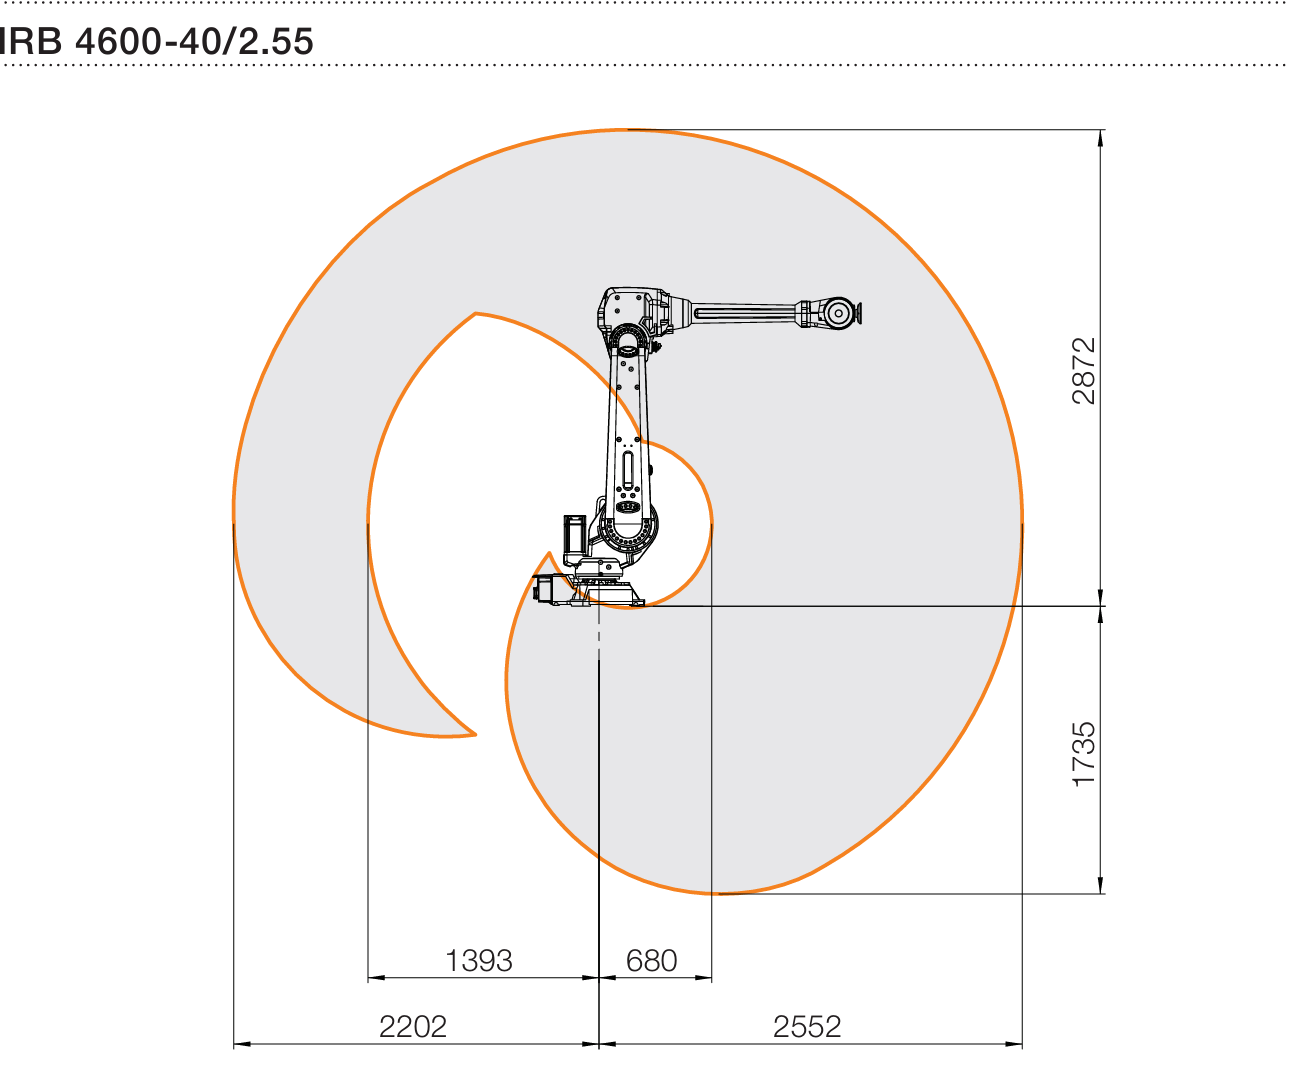

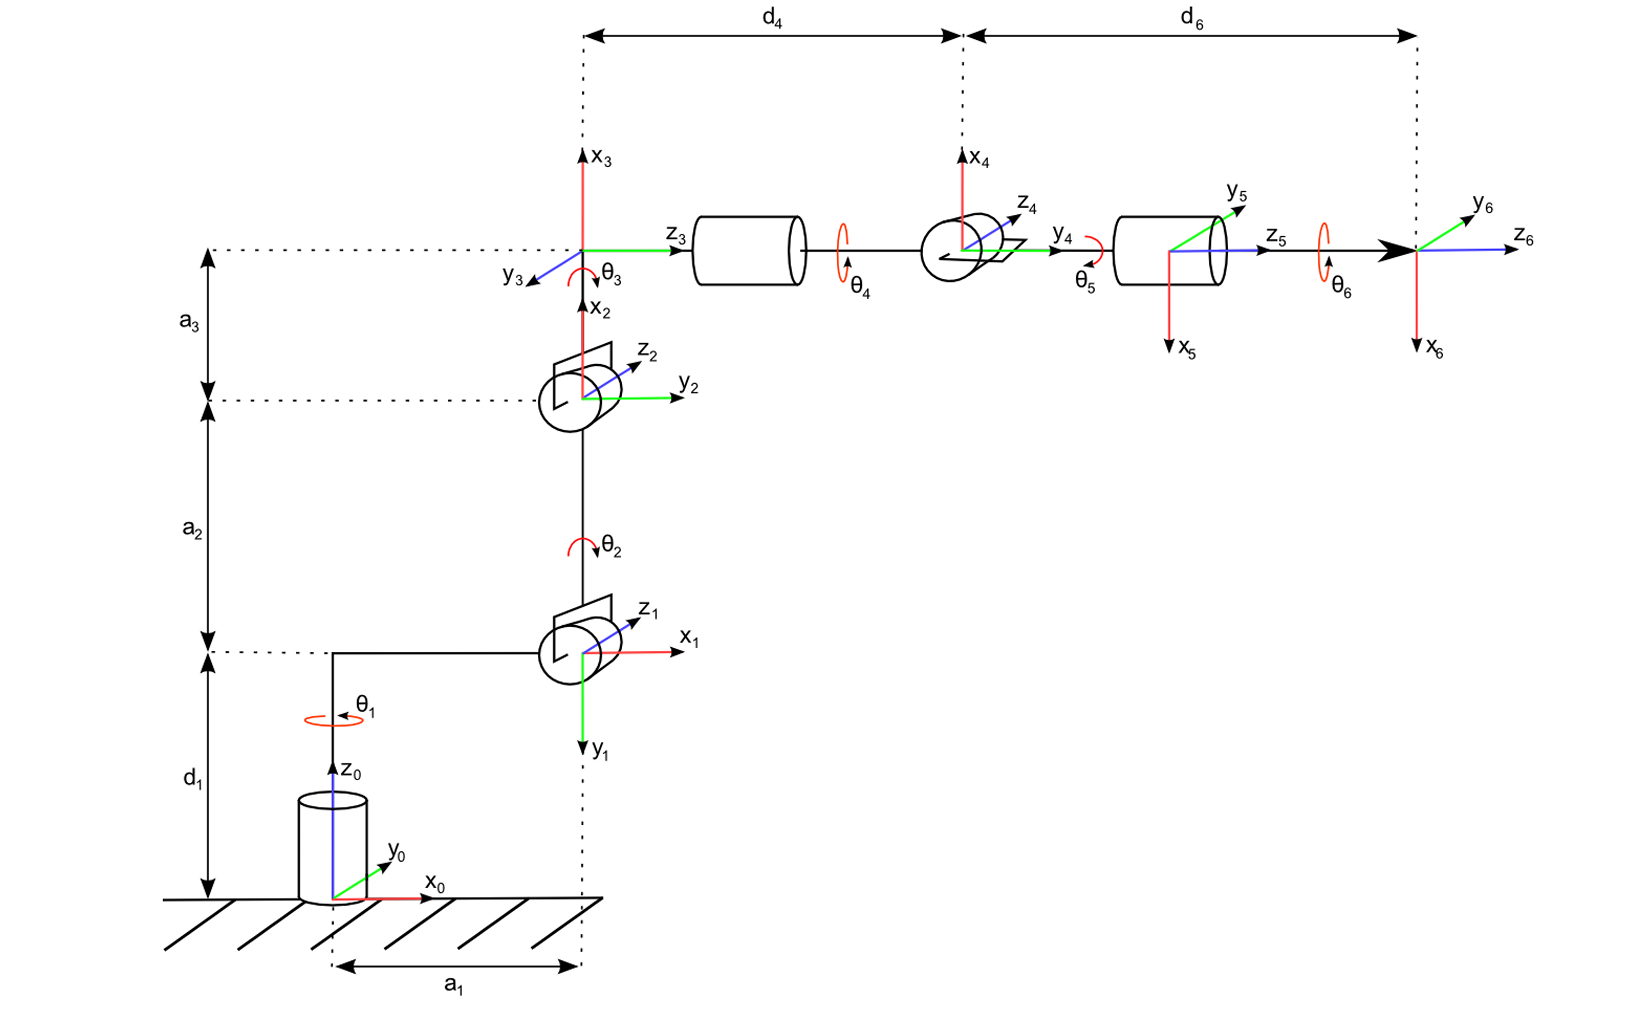

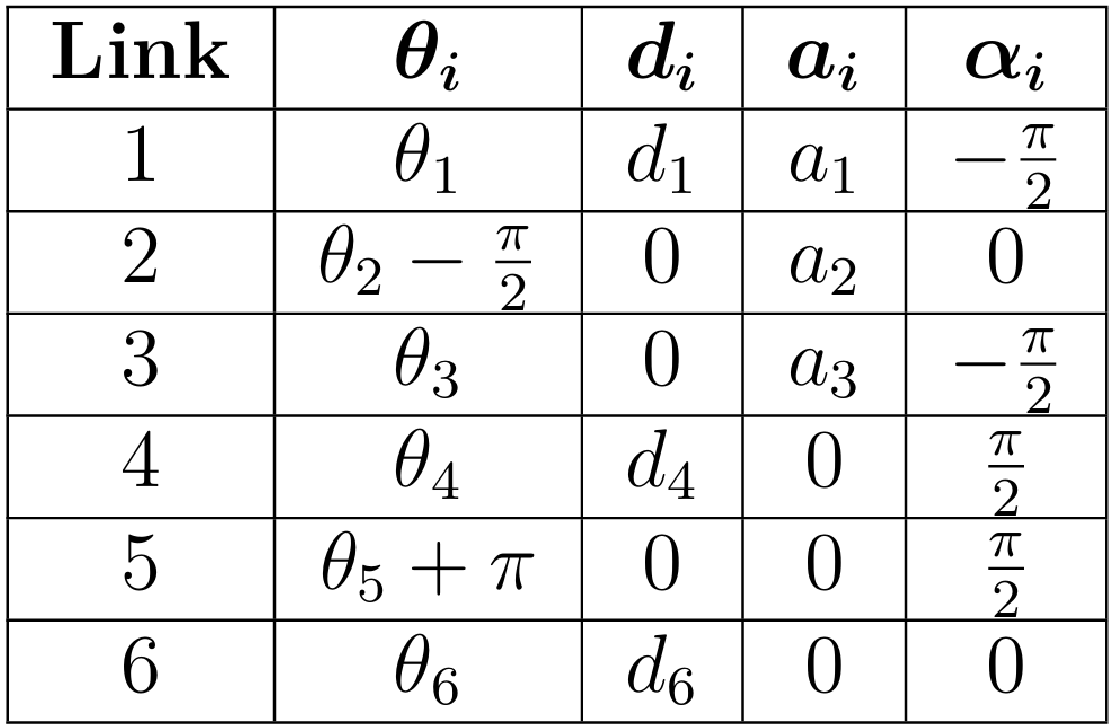

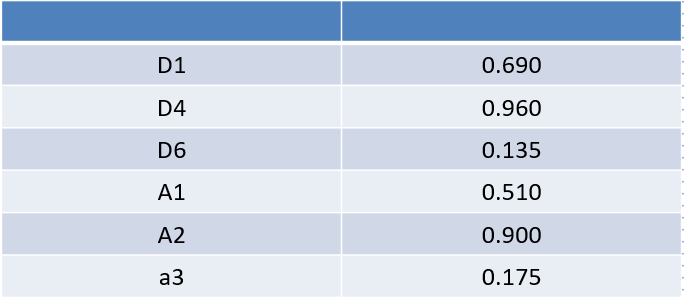

In [ ]:
 # import useful lib
import numpy as np
import time
from coppeliasim_zmqremoteapi_client import RemoteAPIClient

In [ ]:
def FK(theta, alpha, a, d):
    theta = np.radians(theta)
    alpha = np.radians(alpha)
    matrix = np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha),  np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta),  np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),                d],
        [0,              0,                            0,                            1]
    ])
    return np.round(matrix, 3)

In [ ]:
q = np.zeros(6)
for i in range(len(q)):
    q[i] = float(input(f"Please enter the angle for joint {i+1} in degrees: "))
T1 = FK(q[0]     , -90, 0.510  , 0.690)
T2 = FK(q[1]- 90 ,   0, 0.900 ,  0)
T3 = FK(q[2]     , -90, 0.175 , -0)

T4 = FK(q[3]     ,  90,     0 ,  0.960)
T5 = FK(q[4]+180 ,  90,     0 ,  0)
T6 = FK(q[5]     ,   0,     0 ,  0.135)
# Compute the full transformation from base to end-effector
T0_6 = np.round(T1 @ T2 @ T3 @ T4 @ T5 @ T6, 2)
# Print the resulting transformation matrix
print("Final Transformation Matrix T0_6:\n", T0_6)


In [ ]:
client = RemoteAPIClient()

sim = client.require('sim')


defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)
sim.setInt32Param(sim.intparam_idle_fps, 0)

In [ ]:

#Getting names of joints 
joint_names = [f'joint_{i+1}' for i in range(6)]
#Handels of the joints
joint_handles=[sim.getObjectHandle(name) for name in joint_names]
#Assume that the EE is the connection of the last link with the end effector
EE_connection = sim.getObjectHandle("ik_1")
#Lets start
sim.addLog(sim.verbosity_scriptinfos, "Starting the program")

#Graph configuration

EE_graph = sim.getObjectHandle("graph")

EE_x = sim.addGraphStream(EE_graph,"End Effector X position","m",0,[0,1,1])
EE_y = sim.addGraphStream(EE_graph,"End Effector Y position","m",0,[0,0,1])
EE_z = sim.addGraphStream(EE_graph,"End Effector Z position","m",0,[0,1,0])

sim.addGraphCurve(EE_graph,"Position",3,[EE_x,EE_y,EE_z],[0,0,0],"m by m")

In [ ]:
# lets start the simulation
client.setStepping(False)
sim.startSimulation()
#enable the position control for all joints
for i in range(len(joint_handles)):
    sim.setObjectInt32Parameter(joint_handles[i],2001,~0)

for i in range(len(q)):
    sim.setJointTargetPosition(joint_handles[i],np.radians(q[i]))


In [ ]:
#### Robot base joint
Robotbase = joint_handles[0]

# Position of the End Effector
EE_pos = sim.getObjectPosition(EE_connection, -1)
print("Position of the end effector is:\n", EE_pos)

# Transformation matrix
EE_T = np.round(sim.getObjectMatrix(EE_connection, -1), decimals=3
               )
EE_T = EE_T.reshape(3, 4)
print("VREP matrix:\n", EE_T)
print("calculations matrix:\n", T0_6)

# Retrieve graph curve
ret = sim.getGraphCurve(EE_graph, 0, 0)




In [ ]:
# Stop simulation (if required)
sim.stopSimulation()

# Restore the original idle loop frequency
sim.setInt32Param(sim.intparam_idle_fps, defaultIdleFps)
print('Program ended')
